In [19]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.models import efficientnet_b0
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [20]:
# Directorio de datos
data_dir = './archive'

In [21]:
# Dataset personalizado
class CustomDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [22]:
# Función para cargar las imágenes y sus etiquetas
def load_data(data_dir):
    file_paths = []
    labels = []
    class_mapping = {
        "decks/cracked": 0,
        "decks/non-cracked": 1,
        "pavements/cracked": 2,
        "pavements/non-cracked": 3,
        "walls/cracked": 4,
        "walls/non-cracked": 5,
    }
    for label, idx in class_mapping.items():
        folder = os.path.join(data_dir, label)
        if os.path.exists(folder):
            for file in os.listdir(folder):
                file_path = os.path.join(folder, file)
                if os.path.isfile(file_path):
                    file_paths.append(file_path)
                    labels.append(idx)
    return file_paths, labels

In [23]:
# Cargar los datos
file_paths, labels = load_data(data_dir)

# Dividir los datos en entrenamiento, validación y prueba
train_paths, test_paths, train_labels, test_labels = train_test_split(
    file_paths, labels, test_size=0.2, random_state=26, stratify=labels
)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.2, random_state=26, stratify=train_labels
)

# Transformaciones de datos
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Crear los DataLoaders
train_dataset = CustomDataset(train_paths, train_labels, transform=transform)
val_dataset = CustomDataset(val_paths, val_labels, transform=transform)
test_dataset = CustomDataset(test_paths, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [24]:
# Cargar ResNet18 preentrenado
model = efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 6)
# Congelar las capas iniciales
for param in model.features.parameters():
    param.requires_grad = False


# Configurar el criterio de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)


c:\Users\elena\miniconda3\envs\cdi\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\elena\miniconda3\envs\cdi\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\elena/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:02<00:00, 7.98MB/s]


In [25]:
# Entrenamiento
best_val_loss = float('inf')
patience = 3
patience_counter = 0

for epoch in range(10):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # Validación
    model.eval()
    val_loss = 0.0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    val_loss /= len(val_loader)

    # Clasificación
    report = classification_report(y_true, y_pred, output_dict=True)
    val_accuracy = report['accuracy']
    val_f1 = report['weighted avg']['f1-score']

    print(f"Epoch {epoch + 1}/10 - "
          f"Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"Val Accuracy: {val_accuracy:.4f}, "
          f"Val F1-Score: {val_f1:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping activado.")
            break

Epoch 1/10 - Train Loss: 0.9436, Val Loss: 0.7147, Val Accuracy: 0.7137, Val F1-Score: 0.7123
Epoch 2/10 - Train Loss: 0.7207, Val Loss: 0.6602, Val Accuracy: 0.7299, Val F1-Score: 0.7291
Epoch 3/10 - Train Loss: 0.6784, Val Loss: 0.6300, Val Accuracy: 0.7388, Val F1-Score: 0.7381
Epoch 4/10 - Train Loss: 0.6517, Val Loss: 0.6199, Val Accuracy: 0.7343, Val F1-Score: 0.7337
Epoch 5/10 - Train Loss: 0.6488, Val Loss: 0.6050, Val Accuracy: 0.7413, Val F1-Score: 0.7400
Epoch 6/10 - Train Loss: 0.6250, Val Loss: 0.6004, Val Accuracy: 0.7491, Val F1-Score: 0.7472
Epoch 7/10 - Train Loss: 0.6268, Val Loss: 0.5993, Val Accuracy: 0.7476, Val F1-Score: 0.7466
Epoch 8/10 - Train Loss: 0.6254, Val Loss: 0.5905, Val Accuracy: 0.7450, Val F1-Score: 0.7444
Epoch 9/10 - Train Loss: 0.6089, Val Loss: 0.5967, Val Accuracy: 0.7450, Val F1-Score: 0.7444
Epoch 10/10 - Train Loss: 0.6102, Val Loss: 0.5976, Val Accuracy: 0.7410, Val F1-Score: 0.7396


In [26]:
# Evaluación en el conjunto de prueba
test_loss = 0.0
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images, labels
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

test_loss /= len(test_loader)
report = classification_report(y_true, y_pred, target_names=[
    "decks/cracked", "decks/non-cracked", "pavements/cracked",
    "pavements/non-cracked", "walls/cracked", "walls/non-cracked"
])

print(f"Test Loss: {test_loss:.4f}")
print("Classification Report:\n", report)

Test Loss: 0.6089
Classification Report:
                        precision    recall  f1-score   support

        decks/cracked       0.71      0.58      0.63       381
    decks/non-cracked       0.70      0.76      0.73       412
    pavements/cracked       0.82      0.75      0.78       522
pavements/non-cracked       0.81      0.86      0.83       524
        walls/cracked       0.74      0.63      0.68       770
    walls/non-cracked       0.68      0.83      0.75       783

             accuracy                           0.74      3392
            macro avg       0.74      0.73      0.73      3392
         weighted avg       0.74      0.74      0.74      3392



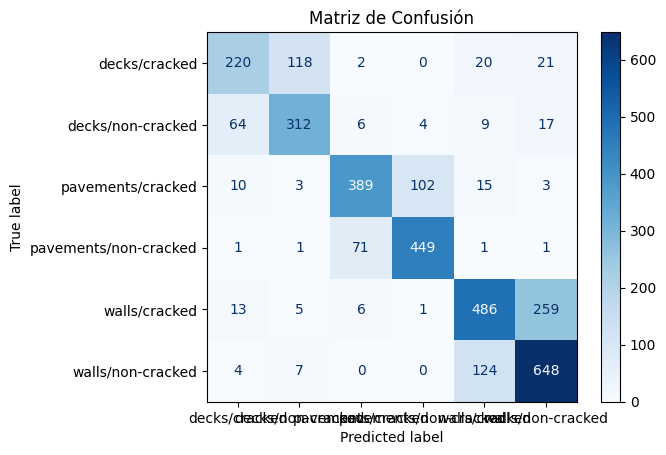

In [27]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[
    "decks/cracked", "decks/non-cracked", "pavements/cracked",
    "pavements/non-cracked", "walls/cracked", "walls/non-cracked"
])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()
